### Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import augmentation as aug
import os
import tensorflow
# from att_lstm import AttentionLSTM

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


### Set seed for reproducibility

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Import dataset and set the directory where to save model, plots of training, scaler and confusion matrix

In [4]:
# directory where to save stuff
dir = 'tests_before_deliver'

if not os.path.exists(dir):
    os.makedirs(dir)

x = np.load('x_train.npy')
y = np.load('y_train.npy')

unique, counts = np.unique(y, return_counts=True)
print(np.asarray((unique, counts)).T)

print(x.shape)
print(y.shape)

[[  0  34]
 [  1 123]
 [  2 270]
 [  3 381]
 [  4  62]
 [  5 153]
 [  6 313]
 [  7  68]
 [  8 120]
 [  9 777]
 [ 10  77]
 [ 11  51]]
(2429, 36, 6)
(2429,)


In [5]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.8, random_state=seed, stratify=y)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)


(1943, 36, 6)
(486, 36, 6)
(1943,)
(486,)


# Preprocessing: Scale the dataset

In [ ]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

scaler = RobustScaler()
# fit the scaler on the training set, then apply it on training and validation set
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_val = scaler.transform(x_val.reshape(-1, x_val.shape[-1])).reshape(x_val.shape)

In [250]:
# save the scaler
import joblib
joblib.dump(scaler, os.path.join(dir, 'scaler.gz'))

['tests_before_deliver\\scaler.gz']

In [251]:
# Inspect activities timestamps: Label & Frequency
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

# Inspect activities timestamps: Label & Frequency
unique, counts = np.unique(y_val, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0  25]
 [  1  92]
 [  2 202]
 [  3 286]
 [  4  46]
 [  5 115]
 [  6 235]
 [  7  51]
 [  8  90]
 [  9 583]
 [ 10  58]
 [ 11  38]]
[[  0   9]
 [  1  31]
 [  2  68]
 [  3  95]
 [  4  16]
 [  5  38]
 [  6  78]
 [  7  17]
 [  8  30]
 [  9 194]
 [ 10  19]
 [ 11  13]]


# Define utilities to plot data augmentation

In [473]:
def plot1d(x, x2=None, x3=None, ylim=(-1, 1), save_file=""):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(6, 3))
    steps = np.arange(x.shape[0])
    plt.plot(steps, x, label='original')
    if x2 is not None:
        plt.plot(steps, x2, label='augmented')
    if x3 is not None:
        plt.plot(steps, x3)
    plt.xlim(0, x.shape[0])
    plt.ylim(ylim)
    plt.tight_layout()
    plt.legend(loc="upper")
    if save_file:
        plt.savefig(save_file, format='pdf')
    else:
        plt.show()
    return

In [477]:
def show_plot(ds, augmented_ds, labels,sample_index, feature_index, filename=''):

    sample = ds[sample_index, :, feature_index]
    augmented_sample = augmented_ds[sample_index, :, feature_index]

    x_sample_max = np.max(sample)
    x_sample_min = np.min(sample)
    aug_max = np.max(augmented_sample)
    aug_min = np.min(augmented_sample)

    max_range = aug_max if aug_max > x_sample_max else x_sample_max
    min_range = aug_min if aug_min < x_sample_min else x_sample_min

    print('looking at feature n.' + str(feature_index)
            + ' of sample n.' + str(sample_index)
            + ' which belongs to class ' + str(labels[sample_index]))

    if filename:
        filepath = os.path.join(dir, filename)
        plot1d(x=sample, x2=augmented_sample, ylim=(min_range, max_range), save_file=filepath)
    else:
        plot1d(sample, augmented_sample, ylim=(min_range, max_range))


# Perform data augmentation only for minority classes
Split the dataset in majority classes (class 9 having 777 samples), minority classes (2, 3, 6 having 200 < samples < 400) and heavy_minority classes (0, 1, 4, 5, 7, 8, 10, 11 having < 200 samples)

In [478]:
minority_samples = []
minority_labels = np.array([])
heavy_minority_samples = []
heavy_minority_labels = np.array([])
majority_samples = []
majority_labels = np.array([])

minority_indices = [2, 3, 6]
heavy_minority_indices = [0, 1, 4, 5, 7, 8, 10, 11]

for sample, label in zip(x_train, y_train):
    if int(label) in minority_indices:
        minority_samples.append(sample)
        minority_labels = np.append(minority_labels, label)
    elif int(label) in heavy_minority_indices:
        heavy_minority_samples.append(sample)
        heavy_minority_labels = np.append(heavy_minority_labels, label)
    else:
        majority_samples.append(sample)
        majority_labels = np.append(majority_labels, label)

minority_samples = np.array(minority_samples)
heavy_minority_samples = np.array(heavy_minority_samples)
majority_samples = np.array(majority_samples)

unique, counts = np.unique(minority_labels, return_counts=True)
print(np.asarray((unique, counts)).T)
print(x_train.shape)

[[  2. 202.]
 [  3. 286.]
 [  6. 235.]]
(1821, 36, 6)
(723, 36, 6)
(1446, 36, 6)
(1446,)


# Apply one single data augmentation technique for minority classes and double the number of samples

In [ ]:
minority_warp_train = aug.magnitude_warp(minority_samples)
minority_aug_train = np.append(minority_samples, minority_warp_train, axis=0)
minority_labels = np.append(minority_labels, minority_labels)

print(minority_samples.shape)
print(minority_aug_train.shape)
print(minority_labels.shape)

# Apply 3 data augmentation techniques for heavy minority classes and increase the size of 8 times

In [258]:
unique, counts = np.unique(heavy_minority_labels, return_counts=True)
print(np.asarray((unique, counts)).T)
print(x_train.shape)

# apply jitter on original
heavy_min_transf1_train = aug.jitter(heavy_minority_samples)
heavy_min_aug_train = np.append(heavy_minority_samples, heavy_min_transf1_train, axis=0)
heavy_minority_labels = np.append(heavy_minority_labels, heavy_minority_labels)

# apply magnitude warp on original and jittered data
heavy_min_transf2_train = aug.magnitude_warp(heavy_min_aug_train)
heavy_min_aug_train = np.append(heavy_min_aug_train, heavy_min_transf2_train, axis=0)
heavy_minority_labels = np.append(heavy_minority_labels, heavy_minority_labels)

# apply scaling on original, jittered, magnitude warp and magnitude-warp-jittered data
heavy_min_transf3_train = aug.scaling(heavy_min_aug_train)
heavy_min_aug_train = np.append(heavy_min_aug_train, heavy_min_transf3_train, axis=0)
heavy_minority_labels = np.append(heavy_minority_labels, heavy_minority_labels)

unique, counts = np.unique(heavy_minority_labels, return_counts=True)
print(np.asarray((unique, counts)).T)
print(x_train.shape)

print(heavy_minority_samples.shape)
print(heavy_min_aug_train.shape)
print(heavy_minority_labels.shape)

[[  0.  25.]
 [  1.  92.]
 [  4.  46.]
 [  5. 115.]
 [  7.  51.]
 [  8.  90.]
 [ 10.  58.]
 [ 11.  38.]]
(1821, 36, 6)
[[  0. 200.]
 [  1. 736.]
 [  4. 368.]
 [  5. 920.]
 [  7. 408.]
 [  8. 720.]
 [ 10. 464.]
 [ 11. 304.]]
(1821, 36, 6)
(515, 36, 6)
(4120, 36, 6)
(4120,)


# Visualize the augmentation

In [479]:
sample_index = 0
feature_index = 0


looking at feature n.2 of sample n.24 which belongs to class 10.0
looking at feature n.2 of sample n.24 which belongs to class 10.0


C:\Users\Leonardo\AppData\Local\Temp\ipykernel_7840\499735784.py:14: MatplotlibDeprecationWarning: Unrecognized location 'upper'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(loc="upper")
C:\Users\Leonardo\AppData\Local\Temp\ipykernel_7840\499735784.py:14: MatplotlibDeprecationWarning: Unrecognized location 'upper'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(loc="upper")


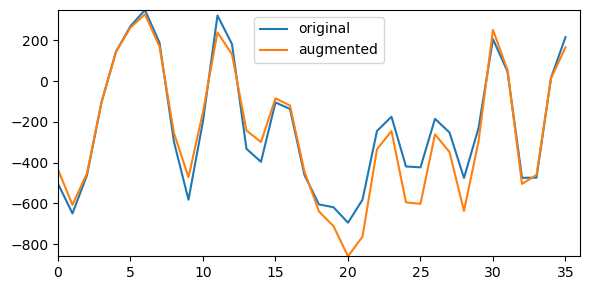

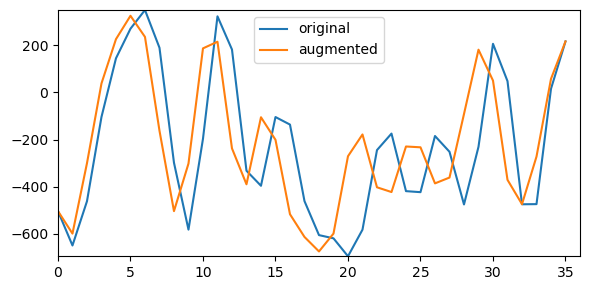

In [480]:
show_plot(minority_samples, minority_warp_train, minority_labels, sample_index, feature_index)
show_plot(heavy_minority_samples, heavy_min_transf1_train, heavy_minority_labels, sample_index, feature_index)

show_plot(heavy_minority_samples, heavy_min_transf2_train, heavy_minority_labels, sample_index, feature_index)
show_plot(heavy_minority_samples, heavy_min_transf3_train, heavy_minority_labels, sample_index, feature_index)

if feature_index < 5:
    feature_index += 1
else:
    feature_index = 0
    sample_index += 1

In [141]:
print(majority_samples.shape)
print(majority_labels.shape)
x_train = np.append(majority_samples, minority_aug_train, axis=0)
y_train = np.append(majority_labels, minority_labels)

x_train = np.append(x_train, heavy_min_aug_train, axis=0)
y_train = np.append(y_train, heavy_minority_labels)

(583, 35, 6)
(583,)


In [142]:
print(x_train.shape)
print(y_train.shape)

(6149, 35, 6)
(6149,)


In [143]:
copy_train_x = x_train
copy_train_y = y_train

# Maintain the labels in scalar format to plot the confusion matrix later

In [ ]:
y_train_scalar = y_train
y_val_scalar = y_val

# Convert the labels to one hot-encoding

In [145]:
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)

# Print information to test correctness

In [147]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

unique, counts = np.unique(y_train_scalar.astype(int), return_counts=True)
print(np.asarray((unique, counts)).T)

unique, counts = np.unique(y_val_scalar.astype(int), return_counts=True)
print(np.asarray((unique, counts)).T)

(6149, 35, 6)
(6149, 12)
(608, 35, 6)
(608, 12)
[[  0 200]
 [  1 736]
 [  2 404]
 [  3 572]
 [  4 368]
 [  5 920]
 [  6 470]
 [  7 408]
 [  8 720]
 [  9 583]
 [ 10 464]
 [ 11 304]]
[[  0   9]
 [  1  31]
 [  2  68]
 [  3  95]
 [  4  16]
 [  5  38]
 [  6  78]
 [  7  17]
 [  8  30]
 [  9 194]
 [ 10  19]
 [ 11  13]]


# Define weights to use weighted categorical cross-entropy

In [148]:
# Inspect activities timestamps: Label & Frequency
unique, counts = np.unique(np.argmax(y_train, axis=-1).astype(int), return_counts=True)
print(np.asarray((unique, counts)).T)

labels = list(unique)
n_samples = list(counts)

# dict that will contain the weights for each class
numClasses = {}

for label, n_instances in zip(labels, n_samples):
    numClasses[label] = n_instances

print(numClasses)

majority_class = max(numClasses, key=numClasses.get)
print(majority_class)
majority_value = numClasses[majority_class]

print(numClasses)

for key, value in numClasses.items():
    numClasses[key] = (majority_value / value)

print(numClasses)

[[  0 200]
 [  1 736]
 [  2 404]
 [  3 572]
 [  4 368]
 [  5 920]
 [  6 470]
 [  7 408]
 [  8 720]
 [  9 583]
 [ 10 464]
 [ 11 304]]
{0: 200, 1: 736, 2: 404, 3: 572, 4: 368, 5: 920, 6: 470, 7: 408, 8: 720, 9: 583, 10: 464, 11: 304}
5
{0: 200, 1: 736, 2: 404, 3: 572, 4: 368, 5: 920, 6: 470, 7: 408, 8: 720, 9: 583, 10: 464, 11: 304}
{0: 4.6, 1: 1.25, 2: 2.277227722772277, 3: 1.6083916083916083, 4: 2.5, 5: 1.0, 6: 1.9574468085106382, 7: 2.2549019607843137, 8: 1.2777777777777777, 9: 1.5780445969125214, 10: 1.9827586206896552, 11: 3.026315789473684}


### Build and train models

In [149]:
# FCN model definition
def generate_model(input_shape, classes):

    ip = tfkl.Input(shape=input_shape)

    # gn = tfkl.GaussianNoise(seed=seed, stddev=0.1)(ip)

    conv1 = tfkl.Conv1D(filters=128, kernel_size=8, padding='same')(ip)
    # conv1 = tfkl.BatchNormalization()(conv1)
    conv1 = tfkl.Activation(activation='relu')(conv1)
    conv1 = tfkl.Dropout(0.2)(conv1)

    conv2 = tfkl.Conv1D(filters=256, kernel_size=4, padding='same')(conv1)
    # conv2 = tfkl.BatchNormalization()(conv2)
    conv2 = tfkl.Activation('relu')(conv2)
    conv2 = tfkl.Dropout(0.2)(conv2)

    # conv3 = tfkl.Conv1D(128, kernel_size=3,padding='same')(conv2)
    # # conv3 = tfkl.BatchNormalization()(conv3)
    # conv3 = tfkl.Activation('relu')(conv3)
    # conv3 = tfkl.Dropout(0.2)(conv3)

    gap_layer = tfkl.GlobalMaxPooling1D()(conv2)

    fc = tfkl.Dense(256)(gap_layer)
    fc = tfkl.Dropout(0.3)(fc)
    fc = tfkl.Dense(128)(fc)
    fc = tfkl.Dropout(0.3)(fc)
    fc = tfkl.Dense(64)(fc)

    output_layer = tfkl.Dense(classes, activation='softmax')(fc)

    model = tfk.models.Model(inputs=ip, outputs=output_layer)

    model.summary()
    return model

In [146]:
input_shape = x_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 32
epochs = 1000

In [150]:
model = generate_model(input_shape, classes)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 35, 6)]           0         
                                                                 
 conv1d_17 (Conv1D)          (None, 35, 128)           6272      
                                                                 
 activation_17 (Activation)  (None, 35, 128)           0         
                                                                 
 dropout_31 (Dropout)        (None, 35, 128)           0         
                                                                 
 conv1d_18 (Conv1D)          (None, 35, 256)           131328    
                                                                 
 activation_18 (Activation)  (None, 35, 256)           0         
                                                                 
 dropout_32 (Dropout)        (None, 35, 256)           0   

In [151]:
# tfk.utils.plot_model(model, to_file='model.png')

In [152]:
model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

In [153]:
# Train the model
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(x_val, y_val),
    shuffle=True,
    # class_weight=numClasses,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=25, factor=0.5, min_lr=1e-15)
    ]
).history

Epoch 1/1000
193/193 [==============================] - 4s 15ms/step - loss: 9.2365 - accuracy: 0.1856 - val_loss: 2.4957 - val_accuracy: 0.1645 - lr: 0.0010
Epoch 2/1000
193/193 [==============================] - 3s 14ms/step - loss: 2.7770 - accuracy: 0.2701 - val_loss: 2.3216 - val_accuracy: 0.2319 - lr: 0.0010
Epoch 3/1000
193/193 [==============================] - 3s 15ms/step - loss: 2.5978 - accuracy: 0.2914 - val_loss: 2.3796 - val_accuracy: 0.1480 - lr: 0.0010
Epoch 4/1000
193/193 [==============================] - 3s 15ms/step - loss: 2.1777 - accuracy: 0.3189 - val_loss: 1.9852 - val_accuracy: 0.2516 - lr: 0.0010
Epoch 5/1000
193/193 [==============================] - 3s 14ms/step - loss: 2.0720 - accuracy: 0.3464 - val_loss: 2.0990 - val_accuracy: 0.2418 - lr: 0.0010
Epoch 6/1000
193/193 [==============================] - 3s 14ms/step - loss: 2.1749 - accuracy: 0.3658 - val_loss: 2.1231 - val_accuracy: 0.2681 - lr: 0.0010
Epoch 7/1000
193/193 [==============================

# Visualize accuracy, loss and learning rate decay during the training phase

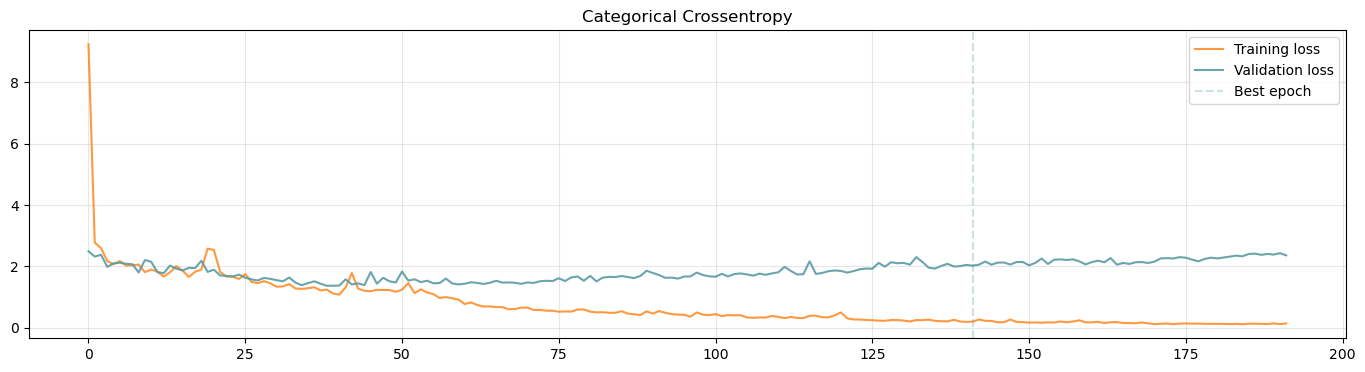

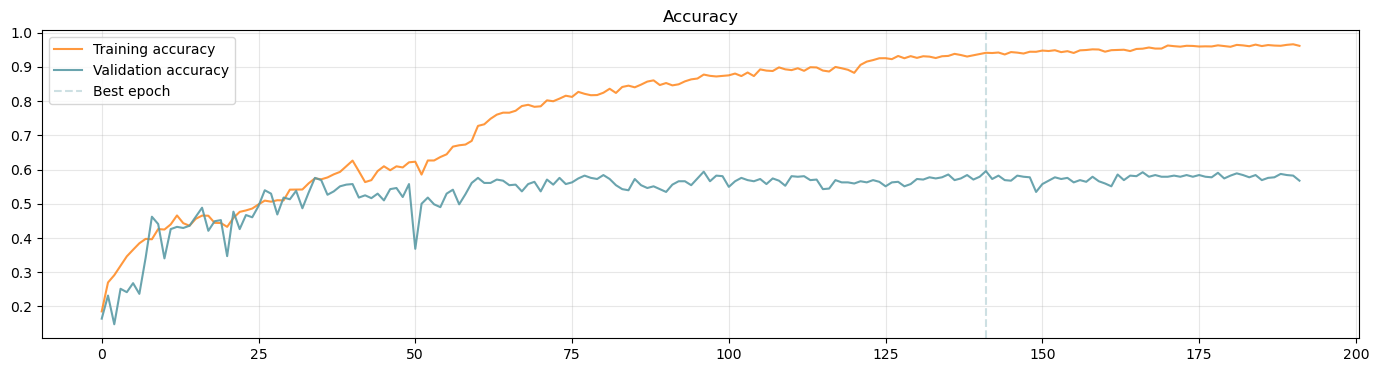

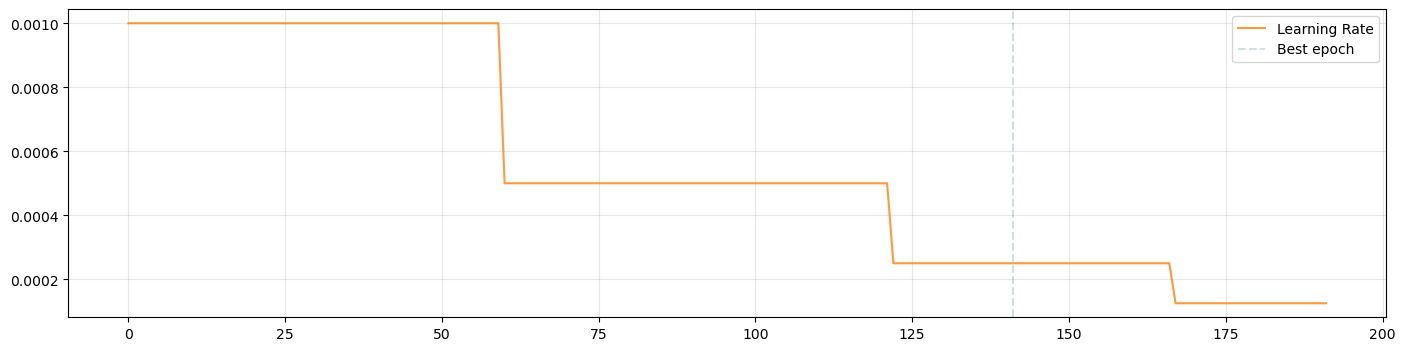

In [154]:
best_epoch = np.argmax(history['val_accuracy'])
fig = plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()
fig.savefig(os.path.join(dir, 'cat_loss_train_val.png'), bbox_inches='tight')


fig = plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()
fig.savefig(os.path.join(dir, 'accuracy_train_val.png'), bbox_inches='tight')


plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()
fig.savefig(os.path.join(dir, 'lr_train_val.png'), bbox_inches='tight')


# Save the model

In [ ]:
model.save(os.path.join(dir, 'fcn'))

# Plot the confusion matrix

In [ ]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          fig_name=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0,
             # ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.xlim(-0.5, len(np.unique(y))-0.5)
    plt.ylim(len(np.unique(y))-0.5, -0.5)
    if fig_name != None:
        fig.savefig(fig_name)
    return ax

predictions = model.predict(x_val)
y_pred = np.argmax(predictions, axis= -1)
labels =  np.unique(y_val_scalar)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
ax = plot_confusion_matrix(y_val_scalar, y_pred, classes=labels,
                      title='Confusion matrix, without normalization', fig_name=os.path.join(dir, 'confmat.pdf'))

# # Plot normalized confusion matrix
# plot_confusion_matrix(y_val_scalar, y_pred, classes=labels, normalize=True,
#                       title='Normalized confusion matrix', fig_name='confmat_normalized.png')

plt.show()